In [70]:
import os
from copy import deepcopy

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib.patheffects import Normal, Stroke
import numpy as np
import seaborn as sns
from ezephys import pltools

import heidelberg

## General informations about the data

In [71]:
run_names = ['run_1_15_08_22', 
             'run_2_16_08_22', 
             'run_3_18_08_22', 
             'run_4_22_08_22', 
             'run_5_24_08_22', 
             'run_6_26_08_22', 
             'run_7_29_08_22',
             'run_8_30_08_22',
             'run_9_01_09_22']

hyper_params = {
    'batch size' : [256, 256, 128, 128, 128, 128, 64, 128, 128], # Insert here
    'learning rate' : [2e-3,1e-3,2e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3], # Insert here
    'number of hidden units' : [200,200,200,200,300,400,300,50,150] # Insert here
}

number_of_seeds = 10
save = True
titles = False
test_used = 'Wilcoxon' # 't-test_welch', 'Wilcoxon'
dpi = 600
one_palette_for_all = 'Set1_r'
train_or_test = 'test' # 'test', 'train'

## What were the hyper parameters tested:

In [72]:
hp = pd.DataFrame(hyper_params)

hp['hyper parameter combination'] = range(9)
hp['hyper parameter combination'] += 1


column_names = ["hyper parameter combination", "batch size", "learning rate", "number of hidden units"]

hp = hp.reindex(columns=column_names)
hp.to_excel('hp.xlsx')

hp

,hyper parameter combination,batch size,learning rate,number of hidden units
0,1,256,0.002,200
1,2,256,0.001,200
2,3,128,0.002,200
3,4,128,0.001,200
4,5,128,0.001,300
5,6,128,0.001,400
6,7,64,0.001,300
7,8,128,0.001,50
8,9,128,0.001,150


# Functions taken from `heidelberg-results.ipynb`:

### Lets us extract the training and testing performances from the generated data of a single run with multiple seeds of the `heidelberg.py` experiment.

In [73]:
def load_training_performance(run_name:str, number_of_seeds:int)->pd.DataFrame:
    """Lets us extract the training performances from the generated data of a single run with multiple seeds

    Parameters
    ----------
    run_name : str
        The name of the directory which is already in '../data' folder, containing the outputs of the heidelberg.py experiment.
    number_of_seeds : int
        How many different initialization were used.

    Returns
    -------
    pd.DataFrame
        The training performance.
    """
    DATA_FILE_PREFIX = os.path.join('..', 'data', run_name, 'heidelberg_training_results_')

    performance = []

    for i in range(number_of_seeds):
        single_seed_performance = pd.read_csv(DATA_FILE_PREFIX + str(i) + '.csv')
        single_seed_performance['seed'] = i

        performance.append(single_seed_performance)
    
    performance = pd.concat(performance).reset_index(drop=True)

    train_data = performance.query('epoch in [0, 199]').copy()
    train_data.loc[:, 'time'] = train_data.epoch.astype(str)
    train_data.replace('0', 'initial', inplace=True)
    train_data.replace('199', 'final', inplace=True)
    train_data.reset_index(drop=True, inplace=True)


    return train_data

In [74]:
def load_test_performance(run_name:str, number_of_seeds:int, do_mean_over_seeds:bool=False)->pd.DataFrame:
    """Lets us extract the training performances from the generated data of a single run with multiple seeds

    Parameters
    ----------
    run_name : str
        The name of the directory which is already in '../data' folder, containing the outputs of the heidelberg.py experiment.
    number_of_seeds : int
        How many different initialization were used.
    do_mean_over_seeds : bool, optional
        Wether you want to calculate the mean of the accuracies over each seed, by default False

    Returns
    -------
    pd.DataFrame
        The test performance.
    """
    DATA_FILE_PREFIX = os.path.join('..', 'data', run_name, 'heidelberg_test_accuracy_')

    test = []

    for i in range(number_of_seeds):
        single_seed_performance = pd.read_json(DATA_FILE_PREFIX + str(i) + '.json', orient='index')
        single_seed_performance['seed'] = i

        test.append(single_seed_performance)

    test = pd.concat(test)
    test['model_name'] = test.index
    test.reset_index(drop=True, inplace=True)
    test = test.melt(['model_name', 'seed'], ['initial', 'final'], var_name='time', value_name='accuracy')
    if do_mean_over_seeds:
        test = test.groupby(['model_name', 'time'], as_index=False).mean()
    return test

## Repaeted code put into functions 

In [75]:

from argparse import ArgumentError


def get_best_run_data_for_each_model(df:pd.DataFrame)->pd.DataFrame:
    """Gets a dataframe with the accuracy over different seeds for the best hyper parameter combination of every model. 

    Parameters
    ----------
    df : pd.DataFrame
        A data frame obtained by calling `get_concat_every_test_performance` containing all the searches (i.e. runs) to look through. 

    Returns
    -------
    pd.DataFrame
        The best validation accuracies of all models for their best hyper parameter combination.
    """
    df_only_final_accuracy = df[df.time == 'final']
    df_mean_over_seeds = df_only_final_accuracy.groupby(['model_name', 'time', 'run_id'], as_index=False).mean()
    best_run_performances = []
    for model in df.model_name.unique():
        df_mean_over_seeds_of_model = df_mean_over_seeds[df_mean_over_seeds.model_name==model]
        max_accuracy_lign = df_mean_over_seeds_of_model.loc[df_mean_over_seeds_of_model['accuracy'].idxmax()]
        best_run_id_for_model = max_accuracy_lign['run_id']
        
        df_model_name = df[df.model_name == model]
        df_model_name_only_best_run = df_model_name[df_model_name.run_id == best_run_id_for_model]
        best_run_performances.append(df_model_name_only_best_run)
    
    return pd.concat(best_run_performances)

def get_concat_every_performance(run_names:str, nb_seeds:int, train_or_test:str='test')->pd.DataFrame:
    """Gets all the validation accuracies of all data generated by `heidelberg.py`

    Parameters
    ----------
    run_names : str
        The folder names containing the data generated possibly over different seeds.
    nb_seeds : int
        The number of seeds used for randomness. Equivalent to the sample size. 
    train_or_test : str
        Wether to take the testing or the training accuracy. One of two choices `train` or  `test`. Defaults to `test`

    Returns
    -------
    pd.DataFrame
        All of the validation performances produced by `heidelberg.py`
    """
    every_test_performance = []
    for run_idx, run_name in enumerate(run_names):
        if train_or_test == 'test':
            single_test_performance = load_test_performance(run_name, nb_seeds, do_mean_over_seeds=False)
        elif train_or_test == 'train':
            single_test_performance = load_training_performance(run_name, nb_seeds)
        else:
            raise ArgumentError(message=f'Need to specify which performance to get. One of two: `test` or `train`.\nGot {train_or_test}')
        single_test_performance['run_id'] = run_idx+1
        every_test_performance.append(single_test_performance)
    return pd.concat(every_test_performance)

## Generate a plot with the best testing perfomances for each model from every set of hyper parameters

In [76]:
all_test_perf_pd = get_concat_every_performance(run_names, number_of_seeds, train_or_test=train_or_test)    
data = get_best_run_data_for_each_model(all_test_perf_pd)

In [77]:
from statannotations.Annotator import Annotator
import statannotations

In [78]:
data

,model_name,seed,time,accuracy,run_id
0,One compartment,0,initial,0.051471,5
3,One compartment,1,initial,0.050092,5
6,One compartment,2,initial,0.033548,5
9,One compartment,3,initial,0.069853,5
12,One compartment,4,initial,0.036765,5
15,One compartment,5,initial,0.037684,5
18,One compartment,6,initial,0.027574,5
21,One compartment,7,initial,0.056985,5
24,One compartment,8,initial,0.045956,5
27,One compartment,9,initial,0.058364,5


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

One compartment_final vs. No BAP_final: Wilcoxon test (paired samples) with Bonferroni correction, P_val:5.859e-03 Stat=0.000e+00
No BAP_final vs. BAP_final: Wilcoxon test (paired samples) with Bonferroni correction, P_val:5.801e-01 Stat=1.400e+01
One compartment_final vs. BAP_final: Wilcoxon test (paired samples) with Bonferroni correction, P_val:5.859e-03 Stat=0.000e+00


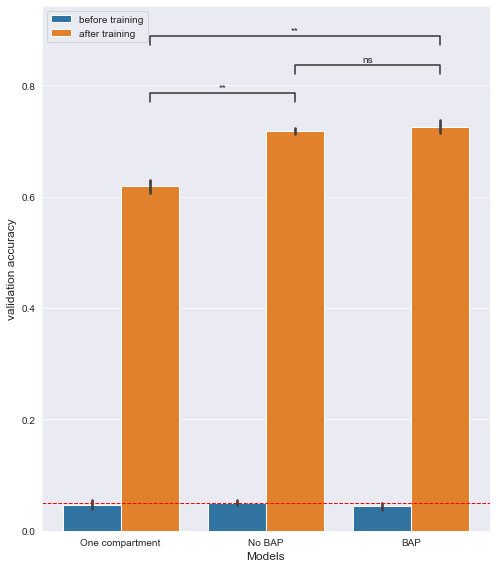

In [79]:
# Set Seaborn style
sns.set_style('darkgrid')

# Construct plot
plt.figure(figsize=(7, 8))

ax = sns.barplot(x = "model_name", y = "accuracy", hue="time", data = data, order=['One compartment', 'No BAP', 'BAP'])#, palette='magma')

pairs = [(("One compartment", "final"), ("BAP", "final")), (("One compartment", "final"), ("No BAP", "final")), (("No BAP", "final"), ("BAP", "final"))]
annot = Annotator(ax, pairs, x = "model_name", y = "accuracy", hue="time", data = data)#, order=['One compartment', 'No BAP', 'BAP'])

if train_or_test == 'test':
    annot.configure(test=test_used, text_format='star', loc='inside', verbose=2, comparisons_correction="Bonferroni")
elif train_or_test == 'train':
    annot.configure(test=test_used, text_format='star', loc='outside', verbose=2, comparisons_correction="Bonferroni")
annot.apply_test()
ax, test_results = annot.annotate()

if titles:
    plt.title(f'Final test accuracy of models with best individual hyper-parameter combinations\n found over {len(run_names)} searches', fontdict={'fontsize': 15})
plt.xlabel(xlabel='Models',
           fontdict={
               'size':12
           }
           )
plt.ylabel(ylabel='validation accuracy',
           fontdict={
               'size':12
           },
           
           )

#plt.yticks(ticks=[0, 1/20, 0.5,0.6,0.7,0.8])


L = plt.legend(title='')
L.get_texts()[0].set_text('before training')
L.get_texts()[1].set_text('after training')


plt.axhline(y=0.05, color ="red", linestyle ="--", linewidth=1)
plt.tight_layout()
if save:
    plt.savefig('../data/heidelberg_hyperparam_visual/figure1.png', dpi=dpi)
plt.show()


In [80]:
color_palettes = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 
                 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 
                 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 
                 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 
                 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 
                 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 
                 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 
                 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 
                 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 
                 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 
                 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 
                 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 
                 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 
                 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 
                 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 
                 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 
                 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 
                 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 
                 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 
                 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 
                 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 
                 'winter', 'winter_r']

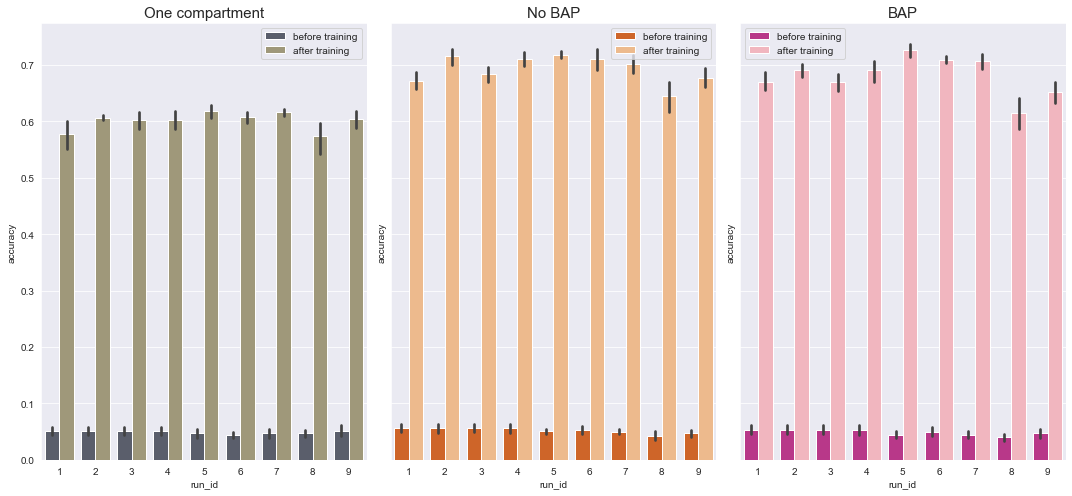

In [81]:
import random

data_max = get_concat_every_performance(run_names,number_of_seeds, train_or_test=train_or_test)
model_names = data_max.model_name.unique()
nb_models=len(model_names)
palette_combo = [color_palettes[random.randint(0, len(color_palettes)-1)] for _ in model_names]

fig, axes = plt.subplots(1, nb_models, figsize=(15, 7), sharey=True)

for ax, model_name, pal in zip(axes, model_names, palette_combo):
    data_per_model = data_max[data_max.model_name == model_name]
    sns.barplot(x="run_id", y="accuracy", hue="time", data=data_per_model, ax=ax, palette=pal)
    ax.set_title(label=model_name, fontdict={'fontsize': 15})
    L = ax.legend(title='')
    L.get_texts()[0].set_text('before training')
    L.get_texts()[1].set_text('after training')

if titles:
    fig.suptitle('All different test performances ', fontsize = 20)#, fontdict={'fontsize': 15})

plt.tight_layout()
if save:
    plt.savefig('../data/heidelberg_hyperparam_visual/figure2.png', dpi=dpi)
plt.show()

color palette chose : pink


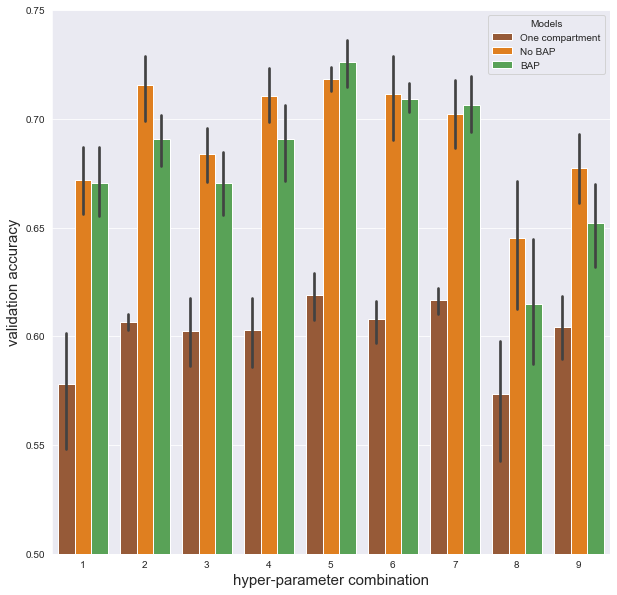

In [82]:
data_max_final = data_max[data_max.time == 'final']

palette_rand_choice = color_palettes[random.randint(0, len(color_palettes)-1)]
print(f'color palette chose : {palette_rand_choice}')
cool_color_palettes = ['mako', 'cool_r', 'cividis_r', 'flare', 'plasma_r', 'copper', 'Oranges_r', 'Oranges', 'YlGnBu_r', 'rainbow_r']

plt.figure(figsize=(10, 10))

if titles:
    plt.title(label='Test performances of each model for different hyper-parameter choices',
            fontdict={
                'size':18
            }
            )

ax = sns.barplot(x="run_id", y="accuracy", hue="model_name", data=data_max_final, palette=one_palette_for_all)



plt.xlabel(xlabel='hyper-parameter combination',
           fontdict={
               'size':15
           }
           )
plt.ylabel(ylabel='validation accuracy',
           fontdict={
               'size':15
           },
           
           )

#plt.yticks(ticks=[0.5,0.6,0.7,0.8])
if train_or_test == 'test':
    plt.ylim([0.5,0.75])
plt.legend(title='Models')

# pairs = [((1, "One compartment"), (5, "One compartment")), ((1, "No BAP"), (5, "No BAP")), ((1, "BAP"), (5, "BAP"))]
# annot = Annotator(ax, pairs, x="run_id", y="accuracy", hue="model_name", data=data_max_final, )

# annot.configure(test=test_used, text_format='star', loc='inside', verbose=2, comparisons_correction="Bonferroni")
# annot.apply_test()
# ax, test_results = annot.annotate()

#plt.tight_layout()
if save:
    plt.savefig('../data/heidelberg_hyperparam_visual/figure3.png', dpi=dpi)
    
plt.show()

## Comparing paper results with best hyper parameter combination found

In [83]:
if train_or_test == 'test':
    run_paper = load_test_performance(run_names[0], number_of_seeds)
    run_best = load_test_performance(run_names[4], number_of_seeds)

elif train_or_test == 'train':
    run_paper = load_training_performance(run_names[0], number_of_seeds)
    run_best = load_training_performance(run_names[4], number_of_seeds)

run_paper = run_paper[run_paper['time']=='final']
run_paper['run_id'] = 1

run_best = run_best[run_best['time']=='final']
run_best['run_id'] = 5

pd_paper_best = pd.concat([run_paper, run_best])

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_BAP vs. 5_BAP: Wilcoxon test (paired samples) with Bonferroni correction, P_val:5.859e-03 Stat=0.000e+00
1_One compartment vs. 5_One compartment: Wilcoxon test (paired samples) with Bonferroni correction, P_val:1.465e-01 Stat=8.000e+00
1_No BAP vs. 5_No BAP: Wilcoxon test (paired samples) with Bonferroni correction, P_val:5.859e-03 Stat=0.000e+00


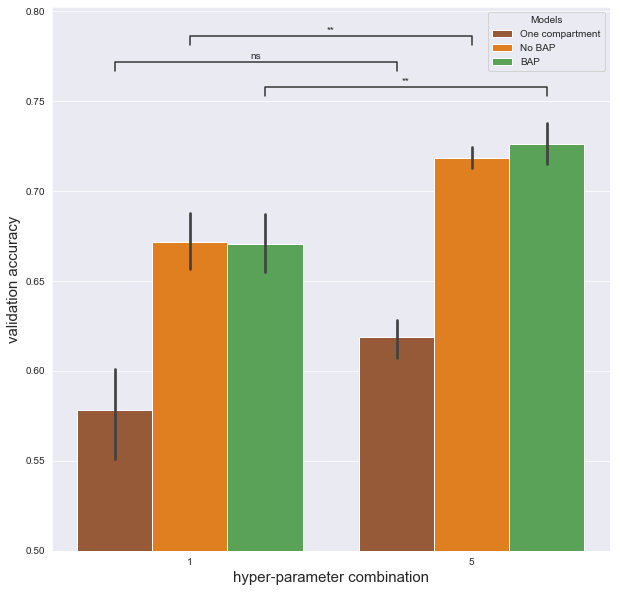

In [84]:
plt.figure(figsize=(10, 10))


ax = sns.barplot(x="run_id", y="accuracy", hue="model_name", data=pd_paper_best, palette=one_palette_for_all)


plt.xlabel(xlabel='hyper-parameter combination',
           fontdict={
               'size':15
           }
           )
plt.ylabel(ylabel='validation accuracy',
           fontdict={
               'size':15
           },
           
           )

#plt.yticks(ticks=[0.5,0.6,0.7,0.8])
plt.ylim([0.5,0.75])
plt.legend(title='Models')

pairs = [((1, "One compartment"), (5, "One compartment")), ((1, "No BAP"), (5, "No BAP")), ((1, "BAP"), (5, "BAP"))]
annot = Annotator(ax, pairs, x="run_id", y="accuracy", hue="model_name", data=pd_paper_best, )

annot.configure(test=test_used, text_format='star', loc='inside', verbose=2, comparisons_correction="Bonferroni")
annot.apply_test()
ax, test_results = annot.annotate()

#plt.tight_layout()
if save:
    plt.savefig('../data/heidelberg_hyperparam_visual/figure7.png', dpi=dpi)
    
plt.show()

## Bar plot comparaison of One Compartment model (no dendritic capturing) versus BAP or No BAP (capturing dendritic interactions) if the number of hidden units is of factor 2 
(*2 or /2)

In [85]:
if train_or_test == 'test':
    run_x_units = load_test_performance('run_5_24_08_22', 10) # lr=1e-3, batch_size=128, 150 hidden units 
    run_2x_units = load_test_performance('run_9_01_09_22', 10) # lr=1e-3, batch_size=128, 300 hidden units 

elif train_or_test == 'train':
    run_x_units = load_training_performance('run_5_24_08_22', 10) # lr=1e-3, batch_size=128, 150 hidden units 
    run_2x_units = load_training_performance('run_9_01_09_22', 10) # lr=1e-3, batch_size=128, 300 hidden units 

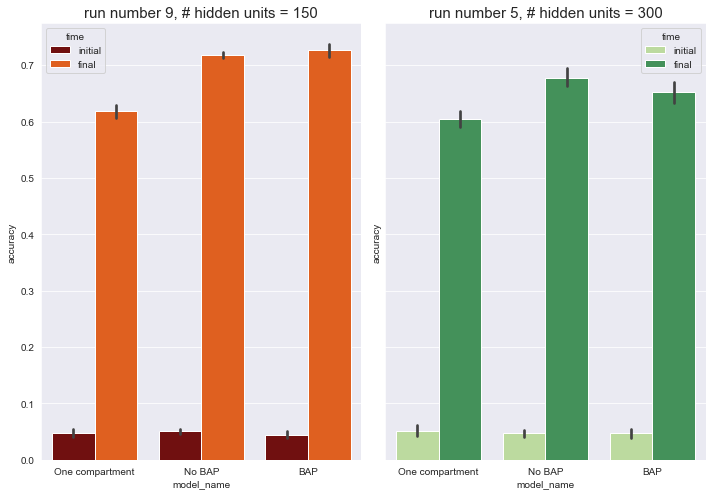

In [86]:
# Create two plots side by side.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7), sharey=True)

sns.set_style('darkgrid')

# Construct plot for run_4_22_08_22 data
sns.barplot(x = "model_name", y = "accuracy", hue="time", data = run_x_units, order=['One compartment', 'No BAP', 'BAP'], ax=ax1, palette="gist_heat")
ax1.set_title(label='run number 9, # hidden units = 150', fontdict={'fontsize': 15})

# Construct plot for run_6_26_08_22 data
sns.barplot(x = "model_name", y = "accuracy", hue="time", data = run_2x_units, order=['One compartment', 'No BAP', 'BAP'], ax=ax2, palette = "YlGn")
ax2.set_title(label='run number 5, # hidden units = 300', fontdict={'fontsize': 15})

if titles:
    fig.suptitle('Difference of accuracies across models for a different number of hidden compartments', fontsize = 18)#, fontdict={'fontsize': 15})


plt.tight_layout()
if save:
    plt.savefig('../data/heidelberg_hyperparam_visual/figure4.png', dpi=dpi)
plt.show()

The fourth search has hyper-parameters : lr=1e-3, batch_size=128, 200 hidden units 

The sixth search has hyper-parameters : lr=1e-3, batch_size=128, 400 hidden units 

Let us compare the `One compartment` of search no6 model with the `BAP` and `No BAP` model of search no4. We are doing this because the models capturing the dendritic phenomena have dual compartments, therefore have 2 times more computational units than a standard model like the `One Compartment`.

In [87]:
one_compartment = run_2x_units[run_2x_units.model_name=='One compartment'][run_2x_units.time=='final']
one_compartment.reset_index(drop=True, inplace=True)

bap = run_x_units[run_x_units.model_name=='BAP'][run_x_units.time=='final']
bap.reset_index(inplace=True, drop=True)

no_bap = run_x_units[run_x_units.model_name=='No BAP'][run_x_units.time=='final']
no_bap.reset_index(inplace=True, drop=True)

df = pd.concat([one_compartment, no_bap, bap])

/var/folders/xd/10nyn_j13qs58rww11sjkgy80000gn/T/ipykernel_3275/2584262359.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/xd/10nyn_j13qs58rww11sjkgy80000gn/T/ipykernel_3275/2584262359.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/xd/10nyn_j13qs58rww11sjkgy80000gn/T/ipykernel_3275/2584262359.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

One compartment vs. No BAP: Wilcoxon test (paired samples) with Bonferroni correction, P_val:5.859e-03 Stat=0.000e+00
No BAP vs. BAP: Wilcoxon test (paired samples) with Bonferroni correction, P_val:5.801e-01 Stat=1.400e+01
One compartment vs. BAP: Wilcoxon test (paired samples) with Bonferroni correction, P_val:5.859e-03 Stat=0.000e+00


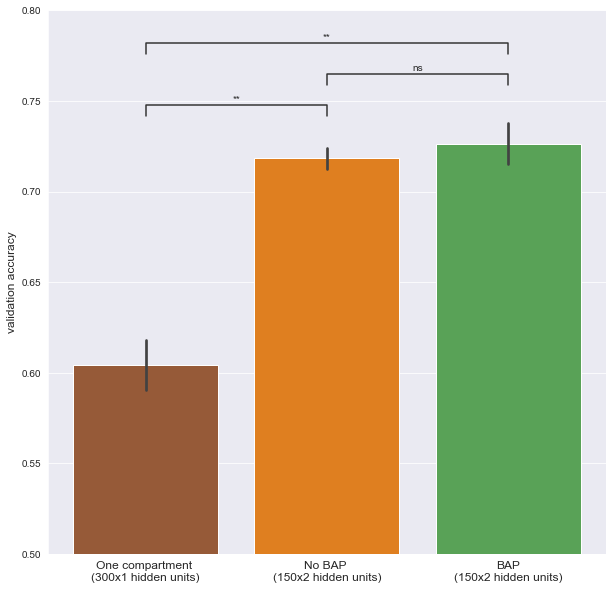

In [88]:
# Construct plot
title = 'Compairing validation accuracies. Two compartment models have\n 150 hidden units and one compartment model has 300 hidden units.'

plt.figure(figsize=(10, 10))

ax = sns.barplot(x = "model_name", y = "accuracy", data=df, order=['One compartment', 'No BAP', 'BAP'], palette = one_palette_for_all)
plt.ylim([0.5,0.8])

pairs = [('One compartment','No BAP'), ('One compartment', 'BAP'), ('No BAP', 'BAP')]
annot = Annotator(ax, pairs, x = "model_name", y = "accuracy", data = df, order=['One compartment', 'No BAP', 'BAP'])

annot.configure(test=test_used, text_format='star', loc='inside', verbose=2, comparisons_correction="Bonferroni")
annot.apply_test()
ax, test_results = annot.annotate()

if titles:
    ax.set_title(title, fontdict={'fontsize': 18})
#plt.title(title, fontdict={'fontsize': 18})

plt.xlabel(xlabel='',
           fontdict={
               'size':12
           }
           )
plt.ylabel(ylabel='validation accuracy',
           fontdict={
               'size':12
           }
           )



ax.set_xticklabels(['One compartment \n(300x1 hidden units)', 'No BAP \n(150x2 hidden units)', 'BAP\n(150x2 hidden units)'], 
                   fontdict={'fontsize':12}
                   )
#plt.tight_layout()
if save:
    plt.savefig('../data/heidelberg_hyperparam_visual/figure5.png', dpi=dpi)
plt.show()

## Preparing the 3d interactive plots

In [89]:
# Dictionnary of hyper parameters used for each run (one batch_size, lr and #hidden units per run)
from typing import Dict, List, Union

def get_hyper_param_dict_dataframe(hyper_params:Union[Dict[str, Union[float,int]], pd.DataFrame], run_names:List[str], keep_seeds:bool=False)->pd.DataFrame:
    """_summary_

    Parameters
    ----------
    hyper_params : Union[Dict[str, Union[float,int]], pd.DataFrame]
        A dictionnary containing 
    run_names : List[str]
        _description_

    Returns
    -------
    pd.DataFrame
        _description_
    """
    # Convert the dictionnary to a pd.DataFrame
    hyper_params_df = pd.DataFrame(hyper_params)

    # Get the data for all the hyper parameter searches
    maximum_data = get_concat_every_performance(run_names,number_of_seeds, train_or_test=train_or_test)
    # Do an average over x number of seeds.
    if keep_seeds:
        averaged_over_seeds = maximum_data
    else:
        averaged_over_seeds = maximum_data.groupby(['model_name', 'time', 'run_id'], as_index=False).mean()
    # Get rid of the initial test accuracies.
    only_final = averaged_over_seeds[averaged_over_seeds.time == 'final']

    # Get all the model names present in the hyper param searches
    model_names = maximum_data.model_name.unique()

    # Initialize a dictionnary with keys being the model names and the items being the corresponding data frames
    # with accuracies and corresponding hyper parameters.
    hyper_params_for_models = [] #@ {}
    # Loop over every model.
    for model_name in model_names:
        df = only_final[only_final.model_name==model_name]
        # Only take the accuracy, model_name, and run_id column of the model.
        if keep_seeds:
            df = df.drop(columns=['time'])
        else:
            df = df.drop(columns=['time', 'seed'])
        df.reset_index(drop=True, inplace=True)
        # Concatenate the accuracy of the model for every search with the corresponding hyper parameters.
        df = pd.concat([hyper_params_df, df], axis=1)
        # Add an id for retracability.
        #df['run_id'] = run_names
        # Add the data frame as an item to dictionnary.
        hyper_params_for_models.append(df) #@hyper_params_for_models[model_name]=df 
    return pd.concat(hyper_params_for_models)#@hyper_params_for_models

hyper_params_for_models = get_hyper_param_dict_dataframe(hyper_params=hyper_params, run_names=run_names)


In [90]:
# Visualise how the data looks for the model BAP
hyper_params_for_models[hyper_params_for_models['model_name'] == 'BAP']

,batch size,learning rate,number of hidden units,model_name,run_id,accuracy
0,256,0.002,200,BAP,1,0.670410
1,256,0.001,200,BAP,2,0.690576
2,128,0.002,200,BAP,3,0.670496
3,128,0.001,200,BAP,4,0.690809
4,128,0.001,300,BAP,5,0.726057
5,128,0.001,400,BAP,6,0.709283
6,64,0.001,300,BAP,7,0.706339
7,128,0.001,50,BAP,8,0.614844
8,128,0.001,150,BAP,9,0.652206


In [91]:
# Calculating the upper and lower bounds for each hyper parameter
# Since all hyperparam combinations are the same across models, only take the first model as a reference (in this case 'BAP').

max_bs = hyper_params_for_models['batch size'].max()
min_bs = hyper_params_for_models['batch size'].min()

max_lr = hyper_params_for_models['learning rate'].max()
min_lr = hyper_params_for_models['learning rate'].min()

max_hu = hyper_params_for_models['number of hidden units'].max()
min_hu = hyper_params_for_models['number of hidden units'].min()
#@min_hu = hyper_params_for_models[model_names[0]]['number of hidden units'].min()

In [92]:
percentage_margin = 0.5

range_x=[40,300]
range_x=[min_bs-(percentage_margin*min_bs),max_bs+(percentage_margin*min_bs)]

range_y=[0.5e-3,2.5e-3]
range_y=[min_lr-(percentage_margin*min_lr),max_lr+(percentage_margin*min_lr)]

range_z=[20,500]
range_z=[min_hu-(percentage_margin*min_hu),max_hu+(percentage_margin*min_hu)]

In [93]:
import plotly.express as px

# Plot every model:
for model_name in model_names:
    fig = px.scatter_3d(data_frame=hyper_params_for_models[hyper_params_for_models['model_name'] == model_name], x='batch size', y='learning rate', z='number of hidden units',
                    color='accuracy', range_x=range_x, range_y=range_y, range_z=range_z,
                    title = model_name, hover_name='run_id')

    fig.update_traces(marker_size = 6)
    fig.update_layout(
        title={
            'text': model_name,
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
            })
    fig.show()


## Dimension reduction where batch size (=128) and learning rate (=1e-3) are fixed

In [94]:
searches = ['run_4_22_08_22', 
            'run_5_24_08_22', 
            'run_6_26_08_22', 
            'run_8_30_08_22',
            'run_9_01_09_22']

In [95]:
hyper_params_df = pd.DataFrame(hyper_params)
hyper_params_df = hyper_params_df[hyper_params_df['batch size'] == 128]
hyper_params_df = hyper_params_df[hyper_params_df['learning rate'] == 1e-3]
hyper_params_df.reset_index(drop=True, inplace=True)
#hyper_params['run_id'] = searches
hyper_params_df

,batch size,learning rate,number of hidden units
0,128,0.001,200
1,128,0.001,300
2,128,0.001,400
3,128,0.001,50
4,128,0.001,150


In [96]:
model_names = data.model_name.unique()

hyper_params_repeated_with_index = pd.concat([hyper_params_df]*number_of_seeds)
hyper_params_repeated_with_index = hyper_params_repeated_with_index.sort_index()
hyper_params_repeated_with_index = pd.concat([hyper_params_repeated_with_index]*len(model_names))
hyper_params_repeated_with_index.reset_index(drop=True, inplace=True)
hyper_params_repeated_with_index

,batch size,learning rate,number of hidden units
0,128,0.001,200
1,128,0.001,200
2,128,0.001,200
3,128,0.001,200
4,128,0.001,200
...,...,...,...
145,128,0.001,150
146,128,0.001,150
147,128,0.001,150
148,128,0.001,150


In [97]:
data_for_hidden_dim_analysis = get_hyper_param_dict_dataframe(hyper_params_df.reset_index(drop=True, inplace=True), searches, keep_seeds=True)
#data[data['model_name'] == 'BAP']
data_for_hidden_dim_analysis

,model_name,seed,accuracy,run_id
0,One compartment,0,0.543658,1
1,One compartment,1,0.571691,1
2,One compartment,2,0.608915,1
3,One compartment,3,0.625460,1
4,One compartment,4,0.603401,1
...,...,...,...,...
45,BAP,5,0.620404,5
46,BAP,6,0.664062,5
47,BAP,7,0.673254,5
48,BAP,8,0.637868,5


In [98]:
#data = data.drop(columns=['run_id'])
data_for_hidden_dim_analysis.reset_index(drop=True, inplace=True)

data_for_hidden_dim_analysis
# data['No BAP'] = pd.concat([data['No BAP'], hyper_params_repeated_with_index])
# data['One compartment'] = pd.concat([data['One compartment'], hyper_params_repeated_with_index])

,model_name,seed,accuracy,run_id
0,One compartment,0,0.543658,1
1,One compartment,1,0.571691,1
2,One compartment,2,0.608915,1
3,One compartment,3,0.625460,1
4,One compartment,4,0.603401,1
...,...,...,...,...
145,BAP,5,0.620404,5
146,BAP,6,0.664062,5
147,BAP,7,0.673254,5
148,BAP,8,0.637868,5


In [99]:
data_for_hidden_dim_analysis = pd.concat([data_for_hidden_dim_analysis, hyper_params_repeated_with_index], axis=1)

<Figure size 432x288 with 0 Axes>

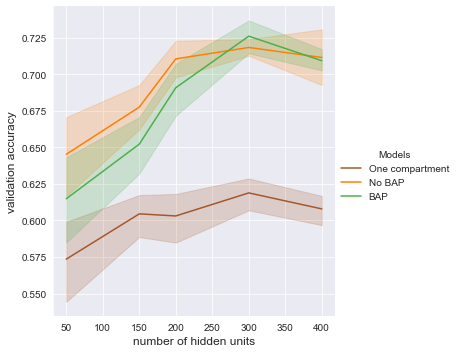

In [100]:
title = (f'Influence of the number of units in the hidden layer\n on validation accuracy')#, {'fontsize': 15})

plt.figure()
g = sns.relplot(data=data_for_hidden_dim_analysis, x='number of hidden units', y='accuracy', kind="line", hue='model_name', palette = one_palette_for_all)
#L = plt.legend(title='Models')
g._legend.set_title("Models")
g.set_titles('title')
# g._legend.texts[0].set_text("")
# g._legend.texts[1].set_text("")
# g._legend.texts[2].set_text("")

#plt.title(f'Influence of the number of units in the hidden layer\n on validation accuracy', fontdict={'fontsize': 15})
plt.xlabel(xlabel='number of hidden units',
           fontdict={
               'size':12
           }
           )
plt.ylabel(ylabel='validation accuracy',
           fontdict={
               'size':12
           },
           )
plt.tight_layout

if save:
    plt.savefig('../data/heidelberg_hyperparam_visual/figure6.png', dpi=dpi)
plt.show()



import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")

color_palettes.reverse()

for pal in color_palettes:
    print(pal)
    sns.barplot(x="day", y="total_bill", hue="sex", data=tips, palette=pal)
    plt.show()